Notebook to compute the eigenmode decomposition of 1D diffusion utilizing 
random walk methodology. Used to validate modal markov formulation for calcium
diffusion. Simple 1d diffusion with no reactions.

11 nodes.

author: Margot Wagner
date created: 6/16/22

### setup

In [2]:
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt
import math
from typing import Union, Tuple

In [3]:
# constants
# create mesh
n_spatial_locs = 11  # define number of grid points along 1D line
dt = 1  # time step (usec)
n_time_pts = 1000  # number of time points

particle_start_loc = 5  # starting position for molecules
min_loc = 0  # minimum position
max_loc = n_spatial_locs - 1  # maximum position
last_elem_i = -1  # index for the last element in a list

line_length = 4  # total length of diffusion line (um)
n_particles = 50  # number of molecules
diffusion_constant_D = 2.20e-4  # Calcium diffusion coeff (um^2/usec)

### 1D Random Walk Diffusion Simulation

(implementation similar to GeeksforGeeks' ["Random Walk (Implementation in Python)"](https://www.geeksforgeeks.org/random-walk-implementation-python/))

In [4]:
def get_jump_probability(
    line_length: Union[int,float], 
    n_spatial_locs: int, 
    diffusion_constant_D: float, 
    dt: Union[int,float]
) -> Tuple[float, float]:
    """Find the probability of moving one spot to the left or right based on 
    finite-difference approximations

    params:
        line_length:
            length of line on which molecule is diffusing
        n_spatial_locs:
            number of locations molecule can diffuse to
        diffusion_constant_D:
            calcium diffusion constant
        dt:
            time step

    return:
        - probability of diffusing one spot to the left or right (k*dt)
        - k: diffusion rate constant

    """
    dx = line_length / n_spatial_locs  # distance of one "hop"
    diffusion_rate_constant_k = diffusion_constant_D / dx**2  # rate constant

    return diffusion_rate_constant_k * dt, diffusion_rate_constant_k

In [5]:
def random_walk_simulation(n_particles: int, 
                           n_time_pts: int, 
                           jump_probability: float
                           ) -> np.ndarray:
    """1-D random walk for n_particles from a range of 
    positions = [0, (n_spatial_locs - 1)]

    Args:
      n_particles:
        total number of molecules
      n_time_pts:
        number of time points
      jump_probability:
        probability of particle diffusing to neighboring grid point

    Returns:
      positions of all particles over time - matrix shaped 
        (n_particles, n_time_pts)
    """

    # probabilities depending on if particle is in middle or at edge
    jump_probability_middle = [
        jump_probability,
        1 - 2 * jump_probability,
        jump_probability,
    ]
    jump_probability_edge = [jump_probability, 1 - jump_probability]

    # initialize array for all particle positions (number of particles)
    particle_locs = np.empty((n_particles, n_time_pts), dtype="int64")

    for n in range(n_particles):

        # Initialize starting position (0 to (n_spatial_locs - 1) range)
        positions = [particle_start_loc]

        # sampling probability all at once (1000 timepoints)
        rand = np.random.random(n_time_pts - 1)

        # movement decision conditions
        move_l_cond = rand < jump_probability
        move_r_cond = rand > (1 - jump_probability)
        # stay condition is between the two

        # run simulation for particle n
        # check probability rolls
        for move_left, move_right in zip(move_l_cond, move_r_cond):

            # move left if move_left=True and last position != minimum 
            # position 
            left = move_left and positions[last_elem_i] > min_loc

            # move right if move_right=True and last position != maximum 
            # position 
            right = move_right and positions[last_elem_i] < max_loc

            # stay condition is implied

            # adjust position accordingly
            positions.append(positions[last_elem_i] - left + right)

        # add results to cumulative array
        particle_locs[n] = positions

    return particle_locs

In [6]:
def random_walk_postprocess(
  particle_locs: np.ndarray, 
  plot=False
  ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Post-process 1D random-walk diffusion 
    (counts, normalized counts, means)

    Args:
      particle_locs:
        positions of all particles over time - matrix shaped 
        (n_particles, n_time_pts)

    Returns:
      unnorm_n_per_loc:
        number of particles in each position over time (unnormalized)
      n_per_loc:
        number of particles in each position over time (normalized)
      mean_n_per_loc:
        mean value of particle number at each location over the whole 
        simulation
    """

    # distribution of particles across positions over time
    unnorm_n_per_loc = np.zeros(
        (n_spatial_locs, n_time_pts), dtype="int64"
    )  # number of particles over time
    
    n_per_loc = np.zeros(
        (n_spatial_locs, n_time_pts)
    )  # normalized count over time

    for i in range(n_time_pts):
        # count number of particles in each position
        counts = np.bincount(particle_locs[:, i])

        # resize to include all positions if it doesn't already
        counts.resize(n_spatial_locs)

        # assign number of particles
        unnorm_n_per_loc[:, i] = counts

        # normalize counts and assign
        counts = counts / particle_locs.shape[0]
        n_per_loc[:, i] = counts

    mean_n_per_loc = np.mean(unnorm_n_per_loc, axis=1)

    if plot:
        # plot particle counts for each position
        plt.figure(figsize=(14, 10))

        for i in range(n_spatial_locs):
            plt.plot(list(range(n_time_pts)), n_per_loc[i, :])

        plt.title(
            "Normalized number of particles in each position over time",
            fontsize=20,
        )
        plt.xlabel("timepoint", fontsize=14)
        plt.ylabel("normalized count", fontsize=14)
        plt.legend(list(range(n_spatial_locs)))
        plt.show()

    return unnorm_n_per_loc, n_per_loc, mean_n_per_loc

### Eigenmode Markov Model

In [7]:
def transition_matrix_maker(
    diffusion_rate_constant_k: Union[int,float], 
    n_spatial_locs: int
    ) -> np.ndarray:
    """Builds and returns the transition matrix for the 1D random walk case 
    as given.

    params:
        diffusion_rate_constant_k:
            jump rate constant
        n_spatial_locs:
            number of grid points along line

    returns:
        transition matrix
    """

    # Define A (transition) matrix
    A = np.zeros(
        (n_spatial_locs, n_spatial_locs)
    )  # transition probability between grid points

    # Transition matrix is given by the ODE dynamics equation (using k-values)
    vec_diag = np.full(n_spatial_locs, (-2 * diffusion_rate_constant_k))
    vec_off_diag = np.full(
        (n_spatial_locs - 1), diffusion_rate_constant_k
    )  # off-diagonal values

    # create transition matrix
    A = (
        np.diag(vec_diag, k=0)
        + np.diag(vec_off_diag, k=1)
        + np.diag(vec_off_diag, k=-1)
    )
    A[0, 0] = -diffusion_rate_constant_k
    A[n_spatial_locs - 1, n_spatial_locs - 1] = -diffusion_rate_constant_k

    return A

In [8]:
def get_eigenmode(eigenvalues, t):
    return np.exp(-eigenvalues * t)

In [9]:
def make_eigenmode_plots(eigenvalues):
    time = np.array(range(n_time_pts))

    for i in range(len(eigenvalues)):
        plt.plot(time, get_eigenmode(eigenvalues[i], time))

    plt.show()

In [10]:
def get_eigenvalues_and_vectors(A: np.ndarray, 
                                print_output=True, 
                                plot_eigenmodes=False,
                                plot_eigenvectors=False,
                                ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns the sorted eigenvalues and eigenvectors of matrix A

    Args:
        A: transition matrix

    Returns:
        eigenvalues: 1d matrix of size n_spatial_locs
        eigenvectors: 2d matrix of eigenvectors where columns
                correspond to eigenvalues (ie evec[:,k] <-> eval[k])
        eval_sort_index: argsort index array used to sort eigenvalues.
                Can be used to sort via matrix[eval_sort_index]

    """

    # get eigenvalues/eigenvectors
    # eigenmode[k] is composed of eigenvector[:, k] and eigenvalue[k]
    e_val_unsorted, e_vec_unsorted = eig(A)
    np.set_printoptions(suppress=True)  # gets rid of scientific notation
    
    # sort values and vectors
    eigenvalues = np.sort(e_val_unsorted)
    eval_sort_index = np.argsort(e_val_unsorted)
    eigenvalues[0] = round(eigenvalues[0])
    eigenvectors = e_vec_unsorted[:, eval_sort_index]
    
    # normalize eigenvector values
    eigenvectors = eigenvectors / eigenvectors[0, 0]

    if print_output:
        print("EIGENVALUES")
        print(" ", end="")
        [print(i, end=" " * 5) for i in range(n_spatial_locs)]
        print()
        print(eigenvalues.round(decimals=3))
        print()
        
        print("EIGENVECTORS")
        # eigenvector columns correspond to eigenvalues 
        # (ie evec[:,k] <-> eval[k])
        print("   ", end="")
        [print(i, end=" " * 4) for i in range(n_spatial_locs)]
        print()
        print(eigenvectors.round(decimals=1))
        print()

    if plot_eigenmodes:
        print("EIGENMODES (e^(-eigenvalue * t))")
        ## TODO: ADD LEGEND
        make_eigenmode_plots(eigenvalues)
        
    if plot_eigenvectors:
        #plot each column

    return eigenvalues, eigenvectors, eval_sort_index

In [11]:
def eigenmode_init_conditions(
    eigenvectors: np.ndarray, 
    eval_sort_index: np.ndarray, 
    print_output=True
) -> Tuple[np.ndarray, np.ndarray]:
    """Find the initial normalized number of particles in the positive 
    and negative state of eigenmode k

    params:
        eigenvectors:
            eigenvector columns correspond to eigenvalues 
            (ie evec[:,k] <-> eval[k])
            eigenvector[e, eigenmode (k)]

    return:
        normalized number of particles in each eigenmode at time = 0
    """
    #TODO: FIGURE OUT HOW TO GET NUMBER OF PARTICLES IN EACH POSITION; MATH NOT CLEAR 
    # starting loc given by particle_start_loc

    # new index of starting node location in sorted eigenvalue/vector arrays
    start_loc_eigenvalue_i = np.where(eval_sort_index == particle_start_loc)

    # get eigenvector for starting location, all eigenmodes (v_k)
    start_loc_eigenvector = eigenvectors[start_loc_eigenvalue_i, :]

    # variable fraction component of initial conditions equation
    '''
    fraction_value = (n_particles * start_loc_eigenvector) / (
        np.sqrt(n_particles * (start_loc_eigenvector**2))
    )
    
    '''
    # NOTE: INITIAL CONDITIONS ARE NEGATIVE IF N_TOTAL_PARTICLES IS NOT SQUARED....
    # NEEDS TO BE SQUARED TO MATCH EQUATIONS WHRE N_TOTAL_PARTICLES IS TAKEN OUT OF EQTN
    # TODO: FINALIZE THIS
    # TODO: FIGURE OUT HOW TO GET NUMBER OF PARTICLES IN EACH POSITION; MATH NOT CLEAR
    # SIMPLIFIES TO BE 1 OR 0 FOR NOW 
    fraction_value = (n_particles * start_loc_eigenvector) / (
        np.sqrt(n_particles**2 * (start_loc_eigenvector**2))
    )
        
    n_per_positive_mode = n_particles*(1 + fraction_value) / 2
    n_per_negative_mode = n_particles*(1 - fraction_value) / 2

    if print_output:
        print("EIGENMODE INITIAL CONDITIONS")
        print("POSITIVE")
        print(n_per_positive_mode)
        print("NEGATIVE")
        print(n_per_negative_mode)
        print()

    return n_per_positive_mode, n_per_negative_mode

Transition probability given by 

\begin{equation} 
    P(transition_{\pm k \rightarrow \mp k}) = \frac{\lambda}{2} dt 
\end{equation}

where $\lambda$ is the eigenVALUE (not eigenvector or eigenmode)

In [12]:
def get_eigenmode_transition_probability(
    eigenvalues: np.ndarray, 
    print_output=True
    ) -> np.ndarray:

    transition_probability = (eigenvalues / 2) * dt

    if print_output:
        print("EIGENMODE TRANSITION PROBABILITIES")
        [print(i, end="\t") for i in range(n_spatial_locs)]
        print()
        [
            print("{:0.1e}".format(transition_probability[i]), end=" ")
            for i in range(n_spatial_locs)
        ]
        print()

    return transition_probability

In [13]:
def eigenmode_markov_simulation(
    n_eigenmodes: int,
    init_cond: np.ndarray,
    transition_probability: np.ndarray,
    n_particles: int,
    dt: Union[int, float],
    n_time_pts: int,
    plot=False,
) -> np.ndarray:
    """Markov simulation for eigenmode analysis to capture calcium diffusion 
    over time
    
    params:
        n_eigenmodes:
            number of modes (k not +/- k); equal to number of locations 
            (n_spatial_loc)
        init_cond:
            initial distribution of particles between positive and negative 
            eigenmode states; [positive vector, negative vector]
        transition_probability:
            probability of transitioning between + and - eigenmode states
        n_particles:
            number of particles
        dt:
            timestep
        n_time_pts:
            number of timepoints

    return:
        n_per_eigenmode_state: normalized number of particles in each 
        eigenmode (+/-) at each timepoint
        np aray shape (n_modes x n_time x n_eigenmode_states)
    """
    # positive and negative states
    n_eigenmode_states = 2

    # initialize number of particles
    # n_modes x n_time x n_eigenmode_states (for +/-, this is 2)
    n_per_eigenmode_state = np.zeros(
        (n_spatial_locs, n_time_pts, n_eigenmode_states)
    ).astype("int")

    # assign initial conditions using number of molecules
    for j in range(n_eigenmode_states):
        n_per_eigenmode_state[:, 0, j] = init_cond[j]

    # for each time point
    for i in range(n_time_pts - 1):

        # for each eigenmode
        for k in range(n_spatial_locs):

            # initialize the number of particles that transition
            # [from + -> -, from - -> +]
            n_change = [0, 0]

            # find number of transitions positive/negative eigenmode state;
            for j in range(n_eigenmode_states):

                # sample random numbers equal to number of particles in 
                # current state
                r = np.random.random(n_per_eigenmode_state[k, i, j])

                # sum number of particles that transitioned
                n_change[j] = sum(r < transition_probability[k])

            # update next time point
            for j in range(n_eigenmode_states):
                n_per_eigenmode_state[k, i + 1, j] = (
                    n_per_eigenmode_state[k, i, j]
                    - n_change[j]
                    + n_change[1 - j]
                )

    if plot:
        n_plot_columns = 2
        n_plot_rows = math.ceil(n_spatial_locs / n_plot_columns)
        fig, ax = plt.subplots(n_plot_columns, n_plot_rows, figsize=(14, 10))

        m_count = 0
        for i in range(n_plot_columns):
            for j in range(n_plot_rows):
                for k in range(n_eigenmode_states):
                    if m_count < n_spatial_locs:
                        ax[i, j].plot(
                            list(range(n_time_pts)),
                            n_per_eigenmode_state[m_count, :, k],
                        )
                        ax[i, j].set_title("Eigenmode {}".format(m_count))

                m_count += 1

        # fig.suptitle
        fig.tight_layout()
        plt.show()

    return n_per_eigenmode_state

To transform the <u>number</u> of particles in each eigenmode to the <u>number</u> at each spatial location, we use the following equation:

\begin{equation} 
\begin{split}
    n_i = \sum_k \text{v}_{ik} m_k \\
    = \sum_k \text{v}_{ik} \left( m_{+k} - m_{-k} \right)
\end{split}
\end{equation}





In [14]:
def eigenmodes_to_spatial_nodes(
    n_per_eigenmode_state: np.ndarray, 
    eigenvectors: np.ndarray,
    print_output=True
    ) -> np.ndarray:
    """Calculate the number of particles at each node from the eigenmode 
    representation.

    Args:
        n_per_eigenmode_state: normalize the number of particles in each node;
        np aray shape (n_modes x n_time x n_eigenmode_states)
        eigenvectors: eigenvector of node i (vector); v[:,k] is the eigenvector
        corresponding to the eigenvalue w[k]; (ie evec[:,k] <-> eval[k])
            eigenvector[e, eigenmode (k)]


    Returns:
        np array containing normalized particle counts for each node 
        (n_nodes x n_time_pts)
    """
    # TO-DO: DEBUG FUNCTION 
    
    # initialize node values (n_nodes x n_time_pts)
    node_vals_from_modes = np.zeros((n_spatial_locs, n_time_pts))
    
    # positive - negative
    n_per_eigenmode = (n_per_eigenmode_state[:,:,0] - n_per_eigenmode_state[:,:,1])
    
    
    for i in range(n_spatial_locs):
        evector_node_i = eigenvectors[:, i].reshape((n_spatial_locs, 1))
        
        # inverse transform CHECK HERE
        node_vals_from_modes[i, :] = np.sum((evector_node_i * n_per_eigenmode), axis=0)
        
             
    if print_output:
        import math
        print("NORMALIZED COUNT PER SPATIAL NODE (FROM EIGENMODES) (N_NODES x TIME)")
        print("PRINTING SIMULATION TIME POINTS SEPARATED BY 100 TIME POINTS")
        for i in range(n_spatial_locs):
            print(i, end="\t")
            print((node_vals_from_modes[i,0:n_time_pts:math.ceil(n_time_pts/14)]/n_particles).round(decimals=1))
        print()
    

    return node_vals_from_modes

In [15]:
def graph_num_comparison(
    n1: np.ndarray, 
    n2: np.ndarray, 
    legend_vals=[], 
    title="",
    normalize=True
    ):
    
    """Graph comparing normalized number of particles at each node 
    and in each mode.

    Args:
        n1: normalized number of particles in one condition 
        (particles per time)
        n2: normalized number of particles in one condition 
        (particles per time)
    """
    import math
    # make subplots
    half_n_nodes = math.ceil(n1.shape[0] / 2)
    fig, axes = plt.subplots(half_n_nodes, 2, figsize=(14, 10))
    
    # normalize number of particles
    if normalize:
        n1 = n1 / n_particles
        n2 = n2 / n_particles

    
    for i, ax in enumerate(axes.flat):
        if i == n_spatial_locs:
            break
        ax.plot(list(range(n_time_pts)), n1[i, :])
        ax.plot(list(range(n_time_pts)), n2[i, :])
        ax.legend(legend_vals)
        ax.axhline(y=0, color='black', linestyle='--')
        ax.set_title("{} {}".format(title, i))

    fig.tight_layout()
    plt.show()
    
    print("{} PARTICLES STARTED NODE {}".format(n_particles, particle_start_loc))
    print("NORMALIZATION TURNED ON? \t", normalize)

### Main

NORMALIZED COUNT PER SPATIAL NODE (FROM EIGENMODES) (N_NODES x TIME)
PRINTING SIMULATION TIME POINTS SEPARATED BY 100 TIME POINTS
0	[-1.  -0.3  0.4  1.3  1.4  1.2  1.4  1.6  1.9  1.9  1.8  2.1  1.6  1.4]
1	[-2.8 -2.2 -1.9 -1.  -1.1 -1.1 -0.9 -0.8 -0.5 -0.7 -0.9 -0.6 -1.3 -1.2]
2	[-1.1 -1.2 -0.8 -1.3 -1.  -1.1 -0.9 -0.7 -0.7 -0.4 -0.3 -0.7 -0.  -0.2]
3	[-2.6 -1.8 -1.7 -1.2 -1.1 -0.5 -0.6 -0.3 -0.6 -0.3 -0.2  0.1 -0.1 -0. ]
4	[6.7 5.3 4.6 3.2 2.5 1.7 1.5 0.8 0.7 0.2 0.4 0.  0.2 0.2]
5	[-2.1 -1.8 -1.6 -0.8 -0.6 -0.5 -0.6 -0.7 -0.5 -0.3 -0.6 -0.4 -0.6 -1.3]
6	[4.9 4.3 3.7 3.1 2.5 2.4 2.5 2.6 2.5 2.3 2.2 2.4 2.6 2.1]
7	[-1.6 -2.1 -2.8 -3.4 -3.9 -3.9 -3.8 -3.1 -3.3 -3.7 -3.2 -3.  -2.5 -2.6]
8	[5.1 4.5 4.  3.7 3.4 2.8 2.6 2.8 3.  2.7 3.  3.2 3.1 2.8]
9	[0.8 1.  1.3 1.2 1.4 1.4 1.4 1.5 1.  1.5 1.5 1.2 1.3 1.6]
10	[-0.6 -0.3 -0.5 -0.2 -0.1  0.3  0.6  0.7  0.7  0.1  0.7  1.2  1.1  1. ]

[[-0.98       -0.94       -0.94       ...  1.58        1.54
   1.54      ]
 [-2.79166921 -2.73567646 -2.735676

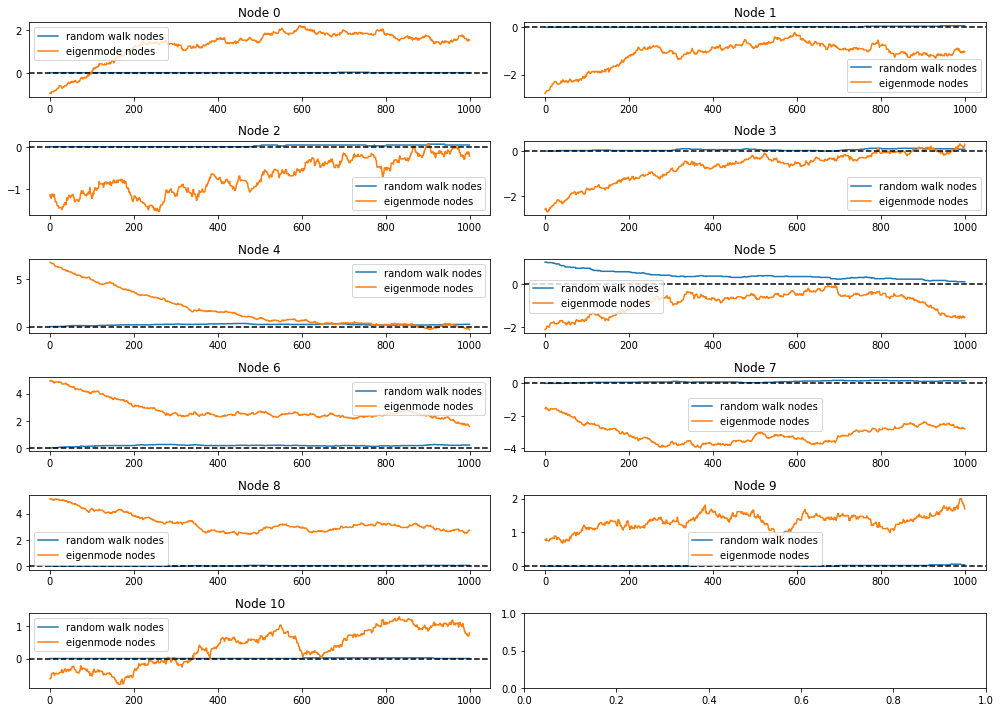

50 PARTICLES STARTED NODE 5
NORMALIZATION TURNED ON? 	 True


In [16]:
def main():

    # find probability of moving one step
    jump_probability, jump_rate_constant_k = get_jump_probability(
        line_length, n_spatial_locs, diffusion_constant_D, dt
    )

    # run simulation
    particle_locs = random_walk_simulation(
        n_particles, n_time_pts, jump_probability
    )

    # plot output
    unnorm_n_per_loc, n_per_loc, mean_n_per_loc = random_walk_postprocess(
        particle_locs, plot=False
    )

    # build transition matrix
    A = transition_matrix_maker(-jump_rate_constant_k, n_spatial_locs)

    # get sorted eigenvalues and eigenvectors (normalized)
    eigenvalues, eigenvectors, eval_sort_index = get_eigenvalues_and_vectors(
        A, print_output=False, plot_eigenmodes=False
    )

    # Find initial values for the number of particles in each eigenmode
    # For n_particles = 1, it should just be 1 and 0 respectively
    init_n_positive_modes, init_n_negative_modes = eigenmode_init_conditions(
        eigenvectors, eval_sort_index, print_output=False
    )

    # initialize eigenmode Markov model transition probabilities
    eigenmode_transition_probability = get_eigenmode_transition_probability(
        eigenvalues, print_output=False
    )

    # run Markov model
    n_per_eigenmode_state = eigenmode_markov_simulation(
        n_spatial_locs,
        [init_n_positive_modes, init_n_negative_modes],
        eigenmode_transition_probability,
        n_particles,
        dt,
        n_time_pts,
        plot=False,
    )
    
    # inverse transform; convert eigenmode representation to node representation
    node_vals_from_modes = eigenmodes_to_spatial_nodes(n_per_eigenmode_state, eigenvectors, print_output=True)
    print(node_vals_from_modes/ n_particles)
    
    # compare with random walk simulation
    graph_num_comparison(
        unnorm_n_per_loc, 
        node_vals_from_modes,
        legend_vals=["random walk nodes", "eigenmode nodes"], 
        title="Node"
        )

if __name__ == "__main__":
    tables_created = main()